In [1]:
# Required imports
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import psutil
import GPUtil

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Install required packages if not already installed
# !pip install facenet-pytorch mtcnn insightface blazeface


Using device: cuda


In [2]:
# Define dataset paths
wider_test_path = "/home/teaching/Documents/assignment/wider_dataset/WIDER_test/images"
wider_train_path = "/home/teaching/Documents/assignment/wider_dataset/WIDER_train/images"
wider_val_path = "/home/teaching/Documents/assignment/wider_dataset/WIDER_val/images"
annotations_path = "/home/teaching/Documents/assignment/wider_dataset/wider_face_split"

# Function to load images from a directory
def load_dataset_sample(path, num_samples=100):
    """Load a sample of images from the dataset for testing"""
    images = []
    categories = os.listdir(path)
    
    for category in categories[:5]:  # Limit to 5 categories for sample
        category_path = os.path.join(path, category)
        if os.path.isdir(category_path):
            files = os.listdir(category_path)
            for file in files[:20]:  # Take 20 images from each category
                if len(images) >= num_samples:
                    break
                img_path = os.path.join(category_path, file)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        images.append((img_path, img))
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
        if len(images) >= num_samples:
            break
    
    return images

# Load a sample of images for testing
test_images = load_dataset_sample(wider_test_path)
print(f"Loaded {len(test_images)} test images")


Loaded 100 test images


In [ ]:
import os
import cv2
import numpy as np
import shutil
from tqdm import tqdm
import glob

def prepare_wider_for_yolo(wider_dataset_path, annotations_path, output_dir):
    """Prepare WIDER dataset for YOLO training based on the specific folder structure"""
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images', 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images', 'val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels', 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels', 'val'), exist_ok=True)
    
    # Corrected path to images directory based on the actual structure
    images_dir = os.path.join(wider_dataset_path, 'WIDER_test', 'WIDER_test', 'images')
    
    # Verify the path exists before proceeding
    if not os.path.exists(images_dir):
        print(f"Error: Directory not found: {images_dir}")
        print("Available directories in WIDER_test:")
        print(os.listdir(os.path.join(wider_dataset_path, 'WIDER_test')))
        return
    
    # Process each category folder
    categories = [d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))]
    
    for category in tqdm(categories, desc="Processing categories"):
        category_path = os.path.join(images_dir, category)
        
        # Get all image files in this category
        image_files = []
        for ext in ['*.jpg', '*.png', '*.jpeg']:
            image_files.extend(glob.glob(os.path.join(category_path, ext)))
        
        for img_path in tqdm(image_files, desc=f"Processing {category}", leave=False):
            img_file = os.path.basename(img_path)
            img_name = os.path.splitext(img_file)[0]
            
            # Read image to get dimensions
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image {img_path}")
                continue
            
            h, w = img.shape[:2]
            
            # Find corresponding annotation
            # Adjust the annotation path based on your actual structure
            anno_file = f"{img_name}.txt"
            anno_path = os.path.join(annotations_path, category, anno_file)
            
            # Decide if this goes to train or val (80/20 split)
            if np.random.rand() < 0.8:
                split = 'train'
            else:
                split = 'val'
            
            # Copy image
            dst_img_path = os.path.join(output_dir, 'images', split, img_file)
            shutil.copy(img_path, dst_img_path)
            
            # If annotation exists, convert to YOLO format
            if os.path.exists(anno_path):
                with open(anno_path, 'r') as f:
                    lines = f.readlines()
                
                yolo_lines = []
                for line in lines:
                    # Parse annotation (format depends on your annotation format)
                    # Assuming format: x, y, width, height
                    parts = line.strip().split(',')
                    if len(parts) >= 4:
                        try:
                            x, y, width, height = map(float, parts[:4])
                            
                            # Convert to YOLO format (normalized center x, center y, width, height)
                            x_center = (x + width/2) / w
                            y_center = (y + height/2) / h
                            norm_width = width / w
                            norm_height = height / h
                            
                            # Class 0 for face
                            yolo_lines.append(f"0 {x_center} {y_center} {norm_width} {norm_height}")
                        except ValueError:
                            print(f"Warning: Could not parse line {line} in {anno_path}")
                
                # Save YOLO annotation
                dst_anno_path = os.path.join(output_dir, 'labels', split, f"{img_name}.txt")
                with open(dst_anno_path, 'w') as f:
                    f.write('\n'.join(yolo_lines))
            else:
                # Create empty annotation file if no annotations exist
                dst_anno_path = os.path.join(output_dir, 'labels', split, f"{img_name}.txt")
                with open(dst_anno_path, 'w') as f:
                    pass

# Define paths based on the dataset structure in the image
wider_dataset_path = '/home/teaching/Documents/assignment/wider_dataset'  # Root directory containing the WIDER dataset
annotations_path = '/home/teaching/Documents/assignment/wider_face_annotations'  # Directory containing annotations
yolo_dataset_dir = '/home/teaching/Documents/assignment/yolo'  # Output directory for YOLO format

# Prepare dataset for YOLO training
prepare_wider_for_yolo(wider_dataset_path, annotations_path, yolo_dataset_dir)

# Create YAML configuration for YOLO training
yaml_content = f"""
path: {os.path.abspath(yolo_dataset_dir)}
train: images/train
val: images/val

nc: 1  # Number of classes
names: ['face']  # Class names
"""

with open(os.path.join(yolo_dataset_dir, 'data.yaml'), 'w') as f:
    f.write(yaml_content)

# Train YOLO model
from ultralytics import YOLO

# Create a new YOLO model from scratch
model = YOLO('yolov8n.yaml')

# Train the model
results = model.train(
    data=os.path.join(yolo_dataset_dir, 'data.yaml'),
    epochs=50,
    imgsz=640,
    batch=16,
    name='yolo_wider_face'
)

# Evaluate the trained model
val_results = model.val()
print(val_results)

Error: Directory not found: /home/teaching/Documents/assignment/wider_dataset/WIDER_test/WIDER_test/images
Available directories in WIDER_test:
['images']
Ultralytics 8.3.111 🚀 Python-3.10.16 torch-2.3.1 CUDA:0 (NVIDIA RTX A5000, 24238MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/home/teaching/Documents/assignment/yolo/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo_wider_face5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=Fa

E0000 00:00:1745130294.300028   81834 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745130294.304402   81834 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745130294.313533   81834 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745130294.313541   81834 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745130294.313543   81834 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745130294.313544   81834 computation_placer.cc:177] computation placer already registered. Please check linka

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /home/teaching/Documents/assignment/yolo/labels/train.cache... 12753 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12753/12753 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/teaching/Documents/assignment/yolo/images/train/2_Demonstration_Protesters_2_231.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/teaching/Documents/assignment/yolo/images/train/37_Soccer_Soccer_37_851.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/teaching/Documents/assignment/yolo/images/train/7_Cheering_Cheering_7_17.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3216.6±1910.1 MB/s, size: 109.9 KB)


val: Scanning /home/teaching/Documents/assignment/yolo/labels/val.cache... 6225 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6225/6225 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/teaching/Documents/assignment/yolo/images/val/7_Cheering_Cheering_7_17.jpg: 1 duplicate labels removed


Plotting labels to runs/detect/yolo_wider_face5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolo_wider_face5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      18.5G      3.011      2.886      2.425          3        640: 100%|██████████| 798/798 [01:03<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:22<00:00,  8.74it/s]


                   all       6225      79673      0.479       0.23      0.227     0.0924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      15.8G      2.165      1.544      1.429         13        640: 100%|██████████| 798/798 [01:00<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.21it/s]


                   all       6225      79673      0.646      0.317      0.353      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      13.8G      1.974      1.319      1.305         51        640: 100%|██████████| 798/798 [00:59<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.13it/s]


                   all       6225      79673      0.687      0.345      0.391      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      13.8G      1.863      1.206      1.258          2        640: 100%|██████████| 798/798 [00:58<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.13it/s]


                   all       6225      79673      0.723       0.39      0.445      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      12.5G      1.797      1.123      1.218        197        640: 100%|██████████| 798/798 [00:57<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.14it/s]


                   all       6225      79673      0.739      0.399      0.451      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      10.7G      1.727      1.053      1.195          2        640: 100%|██████████| 798/798 [00:58<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.21it/s]


                   all       6225      79673      0.752      0.409       0.47      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.21G      1.697      1.023      1.181         35        640: 100%|██████████| 798/798 [00:57<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.20it/s]


                   all       6225      79673      0.754      0.434      0.496      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      17.6G      1.683     0.9892      1.161         18        640: 100%|██████████| 798/798 [00:58<00:00, 13.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.20it/s]


                   all       6225      79673      0.758      0.441        0.5      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      16.9G      1.652     0.9663      1.152         16        640: 100%|██████████| 798/798 [00:58<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.20it/s]


                   all       6225      79673      0.783      0.445      0.518       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.82G      1.623     0.9385      1.143          3        640: 100%|██████████| 798/798 [00:58<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.24it/s]


                   all       6225      79673      0.779      0.453      0.514       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      13.7G        1.6     0.9191      1.141          3        640: 100%|██████████| 798/798 [01:00<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.23it/s]


                   all       6225      79673      0.791      0.464      0.532      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      17.9G      1.599     0.9064      1.133         18        640: 100%|██████████| 798/798 [00:58<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.19it/s]


                   all       6225      79673      0.789      0.471      0.542      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.81G      1.582     0.8911      1.132          4        640: 100%|██████████| 798/798 [00:59<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:18<00:00, 10.41it/s]


                   all       6225      79673      0.784      0.477      0.547      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.83G      1.572     0.8822      1.124          8        640: 100%|██████████| 798/798 [00:58<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.19it/s]


                   all       6225      79673      0.791      0.484      0.551      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      11.9G      1.565      0.877      1.117          7        640: 100%|██████████| 798/798 [00:58<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.22it/s]


                   all       6225      79673      0.798      0.485      0.557      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      18.3G      1.563     0.8657      1.114         22        640: 100%|██████████| 798/798 [00:58<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:18<00:00, 10.27it/s]


                   all       6225      79673      0.802      0.493      0.565      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      12.5G      1.545     0.8479      1.107          4        640: 100%|██████████| 798/798 [00:59<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.17it/s]


                   all       6225      79673      0.802      0.491      0.562      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      18.5G       1.53     0.8348      1.103          1        640: 100%|██████████| 798/798 [00:59<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.24it/s]


                   all       6225      79673      0.809      0.496       0.57      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      11.3G      1.537     0.8366      1.102          4        640: 100%|██████████| 798/798 [00:59<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.16it/s]


                   all       6225      79673      0.803      0.496      0.569      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50        11G      1.522     0.8292      1.095          8        640: 100%|██████████| 798/798 [00:58<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.21it/s]


                   all       6225      79673      0.808      0.506      0.578      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      14.3G      1.523     0.8273      1.102          2        640: 100%|██████████| 798/798 [00:58<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.17it/s]


                   all       6225      79673      0.808      0.506      0.578      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      13.2G      1.503     0.8113      1.093         60        640: 100%|██████████| 798/798 [00:59<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.21it/s]


                   all       6225      79673       0.81      0.509      0.582      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      12.3G       1.51     0.8083      1.089          3        640: 100%|██████████| 798/798 [00:58<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:18<00:00, 10.30it/s]


                   all       6225      79673      0.814       0.51      0.583      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      13.9G      1.499       0.81      1.091         25        640: 100%|██████████| 798/798 [00:58<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:18<00:00, 10.30it/s]


                   all       6225      79673      0.812       0.51      0.584      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50        16G       1.49     0.7929      1.083          3        640: 100%|██████████| 798/798 [00:59<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.24it/s]


                   all       6225      79673      0.813      0.514      0.588      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      17.3G       1.49     0.7978      1.083         36        640: 100%|██████████| 798/798 [00:59<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:18<00:00, 10.27it/s]


                   all       6225      79673      0.817      0.517      0.592      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      11.5G      1.492     0.7816      1.078         48        640: 100%|██████████| 798/798 [00:59<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.24it/s]


                   all       6225      79673      0.814      0.519      0.593      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50        16G      1.488     0.7872       1.08          6        640: 100%|██████████| 798/798 [00:59<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.26it/s]


                   all       6225      79673      0.819      0.519      0.594      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      12.6G      1.477     0.7723      1.076          1        640: 100%|██████████| 798/798 [00:59<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:18<00:00, 10.31it/s]


                   all       6225      79673       0.82      0.522      0.596      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      15.5G       1.47     0.7737      1.076         12        640: 100%|██████████| 798/798 [00:59<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.26it/s]


                   all       6225      79673      0.819      0.524      0.597      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      12.1G      1.462      0.767      1.072         17        640: 100%|██████████| 798/798 [00:59<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.23it/s]


                   all       6225      79673      0.819      0.526      0.601       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      11.1G       1.46     0.7613      1.071          4        640: 100%|██████████| 798/798 [00:58<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.25it/s]


                   all       6225      79673      0.823      0.525      0.599      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      18.8G      1.464     0.7616      1.067          3        640: 100%|██████████| 798/798 [00:59<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:18<00:00, 10.27it/s]


                   all       6225      79673      0.821       0.53      0.604      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      12.6G      1.458     0.7588      1.069          5        640: 100%|██████████| 798/798 [00:58<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.18it/s]


                   all       6225      79673      0.822      0.531      0.606      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      17.8G      1.455     0.7518      1.068         22        640: 100%|██████████| 798/798 [00:58<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:18<00:00, 10.28it/s]


                   all       6225      79673      0.823      0.532      0.607      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50        14G      1.453     0.7505      1.068          1        640: 100%|██████████| 798/798 [00:59<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:18<00:00, 10.28it/s]


                   all       6225      79673      0.823      0.533      0.608      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      13.2G       1.44     0.7447      1.064         14        640: 100%|██████████| 798/798 [00:58<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.19it/s]


                   all       6225      79673      0.822      0.536       0.61      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      16.6G      1.452     0.7442       1.06          4        640: 100%|██████████| 798/798 [00:59<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.23it/s]


                   all       6225      79673      0.826      0.536      0.611      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      11.8G      1.433     0.7405      1.065          4        640: 100%|██████████| 798/798 [00:59<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:18<00:00, 10.43it/s]


                   all       6225      79673      0.822      0.535       0.61      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      11.7G      1.435     0.7318      1.059          7        640: 100%|██████████| 798/798 [00:58<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.22it/s]


                   all       6225      79673      0.822      0.538      0.613      0.338
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      17.8G      1.407     0.7041      1.065          1        640: 100%|██████████| 798/798 [00:57<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:18<00:00, 10.30it/s]


                   all       6225      79673      0.823      0.537      0.611      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      12.5G      1.398     0.6934      1.062          1        640: 100%|██████████| 798/798 [00:57<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:18<00:00, 10.30it/s]


                   all       6225      79673      0.821      0.534       0.61      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      12.3G      1.397     0.6915      1.058          1        640: 100%|██████████| 798/798 [00:56<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.24it/s]


                   all       6225      79673      0.823      0.534      0.612      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      12.9G      1.398     0.6927      1.058         27        640: 100%|██████████| 798/798 [00:57<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:18<00:00, 10.28it/s]


                   all       6225      79673      0.825      0.536      0.612      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      18.1G      1.387     0.6862      1.056          1        640: 100%|██████████| 798/798 [00:56<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:18<00:00, 10.26it/s]


                   all       6225      79673      0.827      0.537      0.615      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      17.9G      1.386     0.6839      1.055          1        640: 100%|██████████| 798/798 [00:56<00:00, 14.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:18<00:00, 10.29it/s]


                   all       6225      79673      0.826      0.537      0.615      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      13.4G      1.378      0.678      1.052          1        640: 100%|██████████| 798/798 [00:57<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:18<00:00, 10.28it/s]


                   all       6225      79673      0.827      0.538      0.615      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      14.7G      1.374     0.6706      1.054          1        640: 100%|██████████| 798/798 [00:56<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:18<00:00, 10.30it/s]


                   all       6225      79673      0.827      0.538      0.616      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      15.4G      1.373     0.6731      1.053         10        640: 100%|██████████| 798/798 [00:57<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:19<00:00, 10.26it/s]


                   all       6225      79673      0.825      0.538      0.615      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      14.1G      1.372     0.6701      1.049          1        640: 100%|██████████| 798/798 [00:56<00:00, 14.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:18<00:00, 10.28it/s]


                   all       6225      79673      0.825      0.538      0.615      0.341

50 epochs completed in 1.091 hours.
Optimizer stripped from runs/detect/yolo_wider_face5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolo_wider_face5/weights/best.pt, 6.2MB

Validating runs/detect/yolo_wider_face5/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.10.16 torch-2.3.1 CUDA:0 (NVIDIA RTX A5000, 24238MiB)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 195/195 [00:21<00:00,  9.23it/s]


                   all       6225      79673      0.827      0.538      0.616      0.342
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/yolo_wider_face5
Ultralytics 8.3.111 🚀 Python-3.10.16 torch-2.3.1 CUDA:0 (NVIDIA RTX A5000, 24238MiB)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3857.9±1055.6 MB/s, size: 91.8 KB)


val: Scanning /home/teaching/Documents/assignment/yolo/labels/val.cache... 6225 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6225/6225 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/teaching/Documents/assignment/yolo/images/val/7_Cheering_Cheering_7_17.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 390/390 [00:23<00:00, 16.56it/s]


                   all       6225      79673      0.826      0.539      0.616      0.343
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/yolo_wider_face52
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b7aca8db3d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.03203

Model Loading


In [3]:
# 1. YOLO Implementation
def load_yolo_model():
    """Load a pre-trained YOLOv8 model for face detection"""
    # Using Ultralytics YOLOv8
    from ultralytics import YOLO
    
    # Load the trained YOLO model
    model = YOLO('/home/teaching/Documents/assignment/yolov8n.pt')
    
    return model


# 2. MTCNN Implementation
def load_mtcnn_model():
    """Load the MTCNN face detection model"""
    from facenet_pytorch import MTCNN
    
    mtcnn = MTCNN(
        image_size=160, 
        margin=0, 
        min_face_size=20,
        thresholds=[0.6, 0.7, 0.7],  # MTCNN thresholds
        factor=0.709, 
        device=device
    )
    
    return mtcnn

def load_centerface_model():
    """Load CenterFace model from GitHub"""
    try:
        import sys
        import subprocess
        import os
        
        # Clone and install the CenterFace repository
        print("Installing CenterFace from GitHub...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "https://github.com/Star-Clouds/CenterFace"])
        
        # Now try to import and use it
        from centerface import CenterFace
        centerface = CenterFace(landmarks=True, use_gpu=torch.cuda.is_available())
        print("CenterFace model loaded successfully")
        return centerface
    except Exception as e:
        print(f"Error installing CenterFace from GitHub: {e}")
        return None


# 4. Haar Cascade Implementation
def load_haar_cascade_model():
    """Load the Haar Cascade face detector"""
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    return face_cascade

# 5. InsightFace Implementation
def load_insightface_model():
    """Load the InsightFace model for face detection and recognition"""
    import insightface
    from insightface.app import FaceAnalysis
    
    app = FaceAnalysis(providers=['CUDAExecutionProvider' if torch.cuda.is_available() else 'CPUExecutionProvider'])
    app.prepare(ctx_id=0, det_size=(640, 640))
    
    return app


In [4]:
# Detection functions for each model
def detect_faces_centerface(image, model):
    """Detect faces using CenterFace model"""
    if model is None:
        return []
    
    h, w = image.shape[:2]
    
    # CenterFace expects RGB images
    if len(image.shape) == 3 and image.shape[2] == 3:
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)
        
        # Convert BGR to RGB if needed
        if image[0,0,0] > image[0,0,2]:  # Simple check if BGR (OpenCV default)
            image = image[..., ::-1]
    
    # Run detection
    dets, landmarks = model(image, h, w)
    
    # Format results as bounding boxes [x1, y1, x2, y2, confidence]
    faces = []
    if dets is not None and len(dets) > 0:
        for i, det in enumerate(dets):
            x1, y1, x2, y2, score = det
            if score > 0.5:  # Confidence threshold
                faces.append([int(x1), int(y1), int(x2), int(y2), score])
    
    return faces


def detect_with_yolo(model, img):
    """Detect faces using YOLOv8"""
    results = model(img)  # Run inference
    if len(results) > 0 and len(results[0].boxes) > 0:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        return boxes
    return np.array([])


def detect_with_mtcnn(model, img):
    """Detect faces using MTCNN"""
    # Convert BGR to RGB (MTCNN expects RGB)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Get boxes and probabilities
    boxes, probs = model.detect(img_rgb)
    if boxes is None:
        return []
    return boxes


def detect_with_haar(model, img):
    """Detect faces using Haar Cascade"""
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = model.detectMultiScale(gray, 1.1, 4)
    if len(faces) == 0:
        return []
    # Convert to [x1, y1, x2, y2] format
    boxes = []
    for (x, y, w, h) in faces:
        boxes.append([x, y, x+w, y+h])
    return np.array(boxes)

def detect_with_insightface(model, img):
    """Detect faces using InsightFace"""
    # InsightFace expects BGR format (OpenCV default)
    faces = model.get(img)
    boxes = []
    for face in faces:
        bbox = face.bbox.astype(int)
        boxes.append(bbox)
    return np.array(boxes)


In [5]:
# Function to measure CPU and GPU usage
def measure_resource_usage():
    """Measure CPU and memory usage"""
    cpu_percent = psutil.cpu_percent()
    memory_info = psutil.virtual_memory()
    memory_used = memory_info.used / (1024 ** 3)  # Convert to GB
    
    # GPU usage if available
    gpu_usage = None
    if torch.cuda.is_available():
        gpu = GPUtil.getGPUs()[0]
        gpu_usage = {
            'gpu_load': gpu.load * 100,
            'gpu_memory_used': gpu.memoryUsed / 1024  # Convert to GB
        }
    
    return {
        'cpu_percent': cpu_percent,
        'memory_used_gb': memory_used,
        'gpu_usage': gpu_usage
    }

# Function to evaluate a model's performance
def evaluate_model(model_name, model, detection_func, test_images, num_runs=3):
    """Evaluate a face detection model's performance"""
    results = {
        'model_name': model_name,
        'detection_times': [],
        'cpu_usage': [],
        'memory_usage': [],
        'gpu_usage': [] if torch.cuda.is_available() else None,
        'detected_faces': [],
        'fps': []
    }
    
    for _ in range(num_runs):
        total_faces = 0
        batch_start_time = time.time()
        
        for img_path, img in tqdm(test_images, desc=f"Evaluating {model_name}"):
            # Measure resource usage before detection
            pre_resources = measure_resource_usage()
            
            # Start timing
            start_time = time.time()
            
            try:
                # Detect faces
                faces = detection_func(model, img)
                
                # End timing
                end_time = time.time()
                detection_time = end_time - start_time
                
                # Measure resource usage after detection
                post_resources = measure_resource_usage()
                
                # Record metrics
                results['detection_times'].append(detection_time)
                results['cpu_usage'].append(post_resources['cpu_percent'] - pre_resources['cpu_percent'])
                results['memory_usage'].append(post_resources['memory_used_gb'] - pre_resources['memory_used_gb'])
                
                if torch.cuda.is_available() and post_resources['gpu_usage'] is not None:
                    results['gpu_usage'].append(post_resources['gpu_usage']['gpu_load'])
                
                if isinstance(faces, np.ndarray):
                    total_faces += len(faces)
                    results['detected_faces'].append(len(faces))
                else:
                    results['detected_faces'].append(0)
                    
            except Exception as e:
                print(f"Error evaluating {model_name}: {e}")
                results['detection_times'].append(float('inf'))
                results['cpu_usage'].append(0)
                results['memory_usage'].append(0)
                if torch.cuda.is_available():
                    results['gpu_usage'].append(0)
                results['detected_faces'].append(0)
        
        batch_end_time = time.time()
        batch_time = batch_end_time - batch_start_time
        fps = len(test_images) / batch_time
        results['fps'].append(fps)
    
    # Calculate averages
    results['avg_detection_time'] = np.mean(results['detection_times'])
    results['avg_cpu_usage'] = np.mean(results['cpu_usage'])
    results['avg_memory_usage'] = np.mean(results['memory_usage'])
    results['avg_fps'] = np.mean(results['fps'])
    
    if torch.cuda.is_available():
        results['avg_gpu_usage'] = np.mean(results['gpu_usage'])
    
    return results


In [6]:
def create_performance_comparison(results):
    """Create performance comparison tables and visualizations"""
    import pandas as pd
    import matplotlib.pyplot as plt
    
    # Create performance comparison dataframe
    performance_data = {
        'Model': [r['model_name'] for r in results],
        'Avg Detection Time (ms)': [r['avg_detection_time'] * 1000 for r in results],
        'FPS': [r['avg_fps'] for r in results],
        'CPU Usage (%)': [r['avg_cpu_usage'] for r in results],
        'Memory Usage (GB)': [r['avg_memory_usage'] for r in results]
    }
    
    if results[0]['avg_gpu_usage'] is not None:
        performance_data['GPU Usage (%)'] = [r['avg_gpu_usage'] for r in results]
    
    df_performance = pd.DataFrame(performance_data)
    print("\nPerformance Comparison:")
    print(df_performance)
    
    # Create detection statistics dataframe
    detection_data = {
        'Model': [r['model_name'] for r in results],
        'Avg Faces Detected': [np.mean(r['detected_faces']) for r in results]
    }
    
    df_detection = pd.DataFrame(detection_data)
    print("\nDetection Statistics:")
    print(df_detection)
    
    # Visualize detection time
    plt.figure(figsize=(10, 6))
    plt.bar(df_performance['Model'], df_performance['Avg Detection Time (ms)'])
    plt.title('Average Detection Time Comparison')
    plt.ylabel('Time (ms)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('detection_time_comparison.png')
    
    # Visualize FPS
    plt.figure(figsize=(10, 6))
    plt.bar(df_performance['Model'], df_performance['FPS'])
    plt.title('Frames Per Second Comparison')
    plt.ylabel('FPS')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('fps_comparison.png')
    
    # Visualize resource usage
    plt.figure(figsize=(12, 6))
    
    # CPU Usage
    plt.subplot(1, 2, 1)
    plt.bar(df_performance['Model'], df_performance['CPU Usage (%)'])
    plt.title('CPU Usage Comparison')
    plt.ylabel('CPU Usage (%)')
    plt.xticks(rotation=45)
    
    # Memory Usage
    plt.subplot(1, 2, 2)
    plt.bar(df_performance['Model'], df_performance['Memory Usage (GB)'])
    plt.title('Memory Usage Comparison')
    plt.ylabel('Memory Usage (GB)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('resource_usage_comparison.png')
    
    print("\nComparison visualizations saved to disk.")


**Main**

Starting comprehensive face detection model evaluation...
Loading models...


/home/teaching/miniconda3/envs/assign/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/teaching/miniconda3/envs/assign/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.2 at onnx/onnx-ml.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/teaching/miniconda3/envs/assign/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.2 at onnx/onnx-operators-ml.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/teaching/miniconda

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/teaching/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/teaching/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/teaching/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/teaching/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/teaching/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

Evaluating YOLOv8:   0%|          | 0/100 [00:00<?, ?it/s]


0: 448x640 1 person, 43.2ms
Speed: 5.6ms preprocess, 43.2ms inference, 126.1ms postprocess per image at shape (1, 3, 448, 640)


Evaluating YOLOv8:   1%|          | 1/100 [00:00<00:51,  1.92it/s]


0: 448x640 2 persons, 3 cars, 1 truck, 4.9ms
Speed: 2.7ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 car, 6.1ms
Speed: 2.1ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Evaluating YOLOv8:   3%|▎         | 3/100 [00:00<00:17,  5.51it/s]


0: 448x640 1 person, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 car, 1 umbrella, 39.9ms
Speed: 2.2ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Evaluating YOLOv8:   5%|▌         | 5/100 [00:00<00:12,  7.70it/s]


0: 480x640 4 persons, 1 truck, 4.8ms
Speed: 1.8ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 1 car, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Evaluating YOLOv8:   7%|▋         | 7/100 [00:00<00:09,  9.78it/s]


0: 448x640 2 persons, 2 cell phones, 8.3ms
Speed: 2.4ms preprocess, 8.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 576x640 2 persons, 1 car, 55.2ms
Speed: 3.5ms preprocess, 55.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Evaluating YOLOv8:   9%|▉         | 9/100 [00:01<00:08, 10.19it/s]


0: 448x640 2 persons, 2 cars, 1 chair, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 car, 1 chair, 6.6ms
Speed: 2.7ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Evaluating YOLOv8:  11%|█         | 11/100 [00:01<00:07, 11.65it/s]


0: 288x640 2 persons, 54.0ms
Speed: 1.6ms preprocess, 54.0ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)

0: 512x640 3 persons, 1 car, 49.1ms
Speed: 3.9ms preprocess, 49.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Evaluating YOLOv8:  13%|█▎        | 13/100 [00:01<00:08, 10.71it/s]


0: 448x640 2 persons, 1 car, 5.2ms
Speed: 2.9ms preprocess, 5.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 1 car, 1 truck, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Evaluating YOLOv8:  15%|█▌        | 15/100 [00:01<00:07, 11.88it/s]


0: 640x608 15 persons, 3 cars, 52.6ms
Speed: 3.6ms preprocess, 52.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)

0: 416x640 1 person, 1 car, 1 chair, 51.8ms
Speed: 1.8ms preprocess, 51.8ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Evaluating YOLOv8:  17%|█▋        | 17/100 [00:01<00:07, 10.89it/s]


0: 448x640 1 person, 1 car, 6.3ms
Speed: 2.8ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 352x640 1 person, 1 bicycle, 59.1ms
Speed: 1.7ms preprocess, 59.1ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Evaluating YOLOv8:  19%|█▉        | 19/100 [00:01<00:07, 10.96it/s]


0: 448x640 1 person, 1 car, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 1 sports ball, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Evaluating YOLOv8:  21%|██        | 21/100 [00:02<00:06, 12.02it/s]


0: 640x448 4 persons, 52.7ms
Speed: 2.1ms preprocess, 52.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 11 persons, 5.0ms
Speed: 2.5ms preprocess, 5.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Evaluating YOLOv8:  23%|██▎       | 23/100 [00:02<00:06, 11.90it/s]


0: 384x640 12 persons, 54.0ms
Speed: 1.8ms preprocess, 54.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 640x640 4 persons, 2 potted plants, 1 sink, 1 vase, 4.7ms
Speed: 3.3ms preprocess, 4.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  25%|██▌       | 25/100 [00:02<00:06, 11.86it/s]


0: 640x384 5 persons, 1 cell phone, 57.6ms
Speed: 2.2ms preprocess, 57.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)

0: 448x640 1 person, 6.2ms
Speed: 3.1ms preprocess, 6.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Evaluating YOLOv8:  27%|██▋       | 27/100 [00:02<00:06, 11.65it/s]


0: 480x640 12 persons, 9.4ms
Speed: 2.5ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x416 2 persons, 53.6ms
Speed: 2.1ms preprocess, 53.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Evaluating YOLOv8:  29%|██▉       | 29/100 [00:02<00:06, 11.54it/s]


0: 576x640 1 person, 7.7ms
Speed: 3.9ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)

0: 480x640 6 persons, 2 umbrellas, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Evaluating YOLOv8:  31%|███       | 31/100 [00:02<00:05, 12.51it/s]


0: 448x640 7 persons, 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 17 persons, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Evaluating YOLOv8:  33%|███▎      | 33/100 [00:03<00:05, 13.24it/s]


0: 640x640 4 persons, 1 tie, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 person, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Evaluating YOLOv8:  35%|███▌      | 35/100 [00:03<00:04, 13.85it/s]


0: 640x544 1 person, 49.9ms
Speed: 2.5ms preprocess, 49.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

0: 480x640 5 persons, 2 cups, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Evaluating YOLOv8:  37%|███▋      | 37/100 [00:03<00:04, 13.15it/s]


0: 384x640 6 persons, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 18 persons, 1 backpack, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Evaluating YOLOv8:  39%|███▉      | 39/100 [00:03<00:04, 13.80it/s]


0: 480x640 6 persons, 1 snowboard, 1 kite, 4.8ms
Speed: 2.5ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 persons, 2 bicycles, 5.9ms
Speed: 2.2ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Evaluating YOLOv8:  41%|████      | 41/100 [00:03<00:04, 14.47it/s]


0: 448x640 9 persons, 2 backpacks, 2 handbags, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 6 persons, 1 teddy bear, 12.1ms
Speed: 3.6ms preprocess, 12.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Evaluating YOLOv8:  43%|████▎     | 43/100 [00:03<00:03, 14.48it/s]


0: 448x640 9 persons, 1 elephant, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Evaluating YOLOv8:  45%|████▌     | 45/100 [00:03<00:03, 14.84it/s]


0: 384x640 16 persons, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 5 persons, 1 backpack, 5.6ms
Speed: 2.0ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Evaluating YOLOv8:  47%|████▋     | 47/100 [00:04<00:03, 15.14it/s]


0: 640x448 3 persons, 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 8 persons, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Evaluating YOLOv8:  49%|████▉     | 49/100 [00:04<00:03, 15.22it/s]


0: 448x640 12 persons, 2 umbrellas, 1 skateboard, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 10 persons, 1 kite, 6.4ms
Speed: 2.5ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Evaluating YOLOv8:  51%|█████     | 51/100 [00:04<00:03, 15.35it/s]


0: 480x640 13 persons, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 12 persons, 1 tie, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Evaluating YOLOv8:  53%|█████▎    | 53/100 [00:04<00:03, 15.46it/s]


0: 384x640 1 person, 1 umbrella, 6.7ms
Speed: 1.5ms preprocess, 6.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 640x448 1 person, 1 scissors, 6.0ms
Speed: 2.3ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Evaluating YOLOv8:  55%|█████▌    | 55/100 [00:04<00:02, 15.65it/s]


0: 448x640 8 persons, 6.6ms
Speed: 2.5ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 13 persons, 1 bottle, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Evaluating YOLOv8:  57%|█████▋    | 57/100 [00:04<00:02, 15.66it/s]


0: 512x640 3 persons, 1 bicycle, 6.0ms
Speed: 2.2ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 10 persons, 1 sports ball, 1 tv, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


Evaluating YOLOv8:  59%|█████▉    | 59/100 [00:04<00:02, 15.67it/s]


0: 544x640 2 persons, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)

0: 416x640 1 person, 2 birds, 7.0ms
Speed: 2.6ms preprocess, 7.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Evaluating YOLOv8:  61%|██████    | 61/100 [00:04<00:02, 14.02it/s]


0: 448x640 6 persons, 3 boats, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Evaluating YOLOv8:  63%|██████▎   | 63/100 [00:05<00:02, 14.53it/s]


0: 384x640 2 persons, 1 chair, 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 416x640 8 persons, 1 horse, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


Evaluating YOLOv8:  65%|██████▌   | 65/100 [00:05<00:02, 14.83it/s]


0: 480x640 2 persons, 1 boat, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Evaluating YOLOv8:  67%|██████▋   | 67/100 [00:05<00:02, 15.20it/s]


0: 640x640 6 persons, 1 car, 1 dog, 1 sports ball, 5.7ms
Speed: 2.3ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 2 persons, 1 baseball glove, 6.0ms
Speed: 1.9ms preprocess, 6.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Evaluating YOLOv8:  69%|██████▉   | 69/100 [00:05<00:01, 15.58it/s]


0: 512x640 3 persons, 2 boats, 1 bird, 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Evaluating YOLOv8:  71%|███████   | 71/100 [00:05<00:01, 15.65it/s]


0: 480x640 2 persons, 1 surfboard, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 8 persons, 5 bottles, 5 wine glasss, 3 cups, 1 bowl, 3 chairs, 3 dining tables, 8.8ms
Speed: 1.8ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)


Evaluating YOLOv8:  73%|███████▎  | 73/100 [00:05<00:01, 15.60it/s]


0: 480x640 3 persons, 2 boats, 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 5 persons, 6.1ms
Speed: 2.5ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Evaluating YOLOv8:  75%|███████▌  | 75/100 [00:05<00:01, 15.70it/s]


0: 576x640 2 persons, 7.3ms
Speed: 3.5ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)

0: 480x640 6 persons, 5 cars, 5.9ms
Speed: 2.1ms preprocess, 5.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Evaluating YOLOv8:  77%|███████▋  | 77/100 [00:05<00:01, 15.69it/s]


0: 448x640 3 persons, 1 bench, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 6 cars, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Evaluating YOLOv8:  79%|███████▉  | 79/100 [00:06<00:01, 15.59it/s]


0: 640x480 2 persons, 49.3ms
Speed: 2.1ms preprocess, 49.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 3 persons, 1 sports ball, 5.7ms
Speed: 2.2ms preprocess, 5.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Evaluating YOLOv8:  81%|████████  | 81/100 [00:06<00:01, 14.34it/s]


0: 448x640 2 persons, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 dog, 1 frisbee, 5.5ms
Speed: 1.9ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Evaluating YOLOv8:  83%|████████▎ | 83/100 [00:06<00:01, 14.86it/s]


0: 448x640 1 person, 6.0ms
Speed: 1.9ms preprocess, 6.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 1 person, 6.1ms
Speed: 1.8ms preprocess, 6.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Evaluating YOLOv8:  85%|████████▌ | 85/100 [00:06<00:00, 15.32it/s]


0: 480x640 2 persons, 1 kite, 6.4ms
Speed: 2.2ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 motorcycles, 5.7ms
Speed: 2.4ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Evaluating YOLOv8:  87%|████████▋ | 87/100 [00:06<00:00, 15.44it/s]


0: 448x640 8 persons, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 5.7ms
Speed: 1.9ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Evaluating YOLOv8:  89%|████████▉ | 89/100 [00:06<00:00, 15.68it/s]


0: 448x640 2 persons, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x576 7 persons, 49.9ms
Speed: 3.5ms preprocess, 49.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Evaluating YOLOv8:  91%|█████████ | 91/100 [00:06<00:00, 14.15it/s]


0: 448x640 1 person, 7.0ms
Speed: 2.6ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Evaluating YOLOv8:  93%|█████████▎| 93/100 [00:07<00:00, 14.55it/s]


0: 640x480 20 persons, 6.2ms
Speed: 2.6ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 7 persons, 2 horses, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Evaluating YOLOv8:  95%|█████████▌| 95/100 [00:07<00:00, 14.97it/s]


0: 448x640 13 persons, 2 backpacks, 1 handbag, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 4.6ms
Speed: 1.6ms preprocess, 4.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Evaluating YOLOv8:  97%|█████████▋| 97/100 [00:07<00:00, 15.37it/s]


0: 448x640 1 person, 1 truck, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 352x640 6 persons, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Evaluating YOLOv8:  99%|█████████▉| 99/100 [00:07<00:00, 15.54it/s]


0: 640x448 1 person, 5.9ms
Speed: 2.2ms preprocess, 5.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Evaluating YOLOv8: 100%|██████████| 100/100 [00:07<00:00, 13.35it/s]


Evaluating MTCNN...


Evaluating MTCNN: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Evaluating Haar Cascade...


Evaluating Haar Cascade: 100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


Evaluating InsightFace...


Evaluating InsightFace: 100%|██████████| 100/100 [02:22<00:00,  1.43s/it]
/tmp/ipykernel_347530/2158878346.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_347530/2158878346.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_347530/2158878346.py:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_347530/2158878346.py:127: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(ax4.get_xticklabel

Creating performance report...
Finding challenging test cases...


Finding challenging cases:   0%|          | 0/50 [00:00<?, ?it/s]


0: 448x640 1 person, 5.3ms
Speed: 18.7ms preprocess, 5.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Finding challenging cases:   2%|▏         | 1/50 [00:00<00:33,  1.46it/s]


0: 448x640 2 persons, 3 cars, 1 truck, 5.9ms
Speed: 3.9ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Finding challenging cases:   4%|▍         | 2/50 [00:01<00:35,  1.35it/s]


0: 448x640 1 person, 1 car, 5.9ms
Speed: 2.2ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Finding challenging cases:   6%|▌         | 3/50 [00:01<00:29,  1.58it/s]


0: 448x640 1 person, 5.8ms
Speed: 2.2ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Finding challenging cases:   8%|▊         | 4/50 [00:02<00:27,  1.69it/s]


0: 480x640 1 person, 1 car, 1 umbrella, 6.2ms
Speed: 2.4ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Finding challenging cases:  10%|█         | 5/50 [00:03<00:25,  1.77it/s]


0: 480x640 4 persons, 1 truck, 5.7ms
Speed: 2.5ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Finding challenging cases:  12%|█▏        | 6/50 [00:04<00:33,  1.32it/s]


0: 448x640 2 persons, 1 car, 6.3ms
Speed: 2.3ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Finding challenging cases:  14%|█▍        | 7/50 [00:04<00:29,  1.45it/s]


0: 448x640 2 persons, 2 cell phones, 5.9ms
Speed: 2.3ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Finding challenging cases:  16%|█▌        | 8/50 [00:05<00:27,  1.54it/s]


0: 576x640 2 persons, 1 car, 6.1ms
Speed: 2.8ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Finding challenging cases:  18%|█▊        | 9/50 [00:05<00:24,  1.64it/s]


0: 448x640 2 persons, 2 cars, 1 chair, 6.2ms
Speed: 2.2ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Finding challenging cases:  20%|██        | 10/50 [00:06<00:22,  1.75it/s]


0: 480x640 1 person, 1 car, 1 chair, 6.1ms
Speed: 2.4ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Finding challenging cases:  22%|██▏       | 11/50 [00:06<00:20,  1.87it/s]


0: 288x640 2 persons, 6.3ms
Speed: 1.6ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


Finding challenging cases:  24%|██▍       | 12/50 [00:07<00:21,  1.80it/s]


0: 512x640 3 persons, 1 car, 6.2ms
Speed: 2.6ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Finding challenging cases:  26%|██▌       | 13/50 [00:08<00:26,  1.41it/s]


0: 448x640 2 persons, 1 car, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Finding challenging cases:  28%|██▊       | 14/50 [00:09<00:25,  1.44it/s]


0: 480x640 2 persons, 1 car, 1 truck, 6.2ms
Speed: 2.5ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Finding challenging cases:  30%|███       | 15/50 [00:09<00:23,  1.50it/s]


0: 640x608 15 persons, 3 cars, 6.2ms
Speed: 3.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Finding challenging cases:  32%|███▏      | 16/50 [00:11<00:36,  1.08s/it]


0: 416x640 1 person, 1 car, 1 chair, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


Finding challenging cases:  34%|███▍      | 17/50 [00:12<00:29,  1.13it/s]


0: 448x640 1 person, 1 car, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Finding challenging cases:  36%|███▌      | 18/50 [00:12<00:25,  1.25it/s]


0: 352x640 1 person, 1 bicycle, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


Finding challenging cases:  38%|███▊      | 19/50 [00:13<00:22,  1.36it/s]


0: 448x640 1 person, 1 car, 6.3ms
Speed: 2.3ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Finding challenging cases:  40%|████      | 20/50 [00:13<00:20,  1.50it/s]


0: 480x640 3 persons, 1 sports ball, 6.2ms
Speed: 2.4ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Finding challenging cases:  42%|████▏     | 21/50 [00:14<00:21,  1.32it/s]


0: 640x448 4 persons, 6.2ms
Speed: 2.7ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Finding challenging cases:  44%|████▍     | 22/50 [00:15<00:24,  1.13it/s]


0: 480x640 11 persons, 6.6ms
Speed: 2.6ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Finding challenging cases:  46%|████▌     | 23/50 [00:18<00:36,  1.36s/it]


0: 384x640 12 persons, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Finding challenging cases:  48%|████▊     | 24/50 [00:21<00:45,  1.75s/it]


0: 640x640 4 persons, 2 potted plants, 1 sink, 1 vase, 6.3ms
Speed: 3.3ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Finding challenging cases:  50%|█████     | 25/50 [00:22<00:40,  1.62s/it]


0: 640x384 5 persons, 1 cell phone, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Finding challenging cases:  52%|█████▏    | 26/50 [00:23<00:34,  1.43s/it]


0: 448x640 1 person, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Finding challenging cases:  54%|█████▍    | 27/50 [00:23<00:26,  1.16s/it]


0: 480x640 12 persons, 6.2ms
Speed: 2.5ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Finding challenging cases:  56%|█████▌    | 28/50 [00:25<00:31,  1.41s/it]


0: 640x416 2 persons, 6.3ms
Speed: 2.5ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Finding challenging cases:  58%|█████▊    | 29/50 [00:27<00:27,  1.33s/it]


0: 576x640 1 person, 6.2ms
Speed: 3.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Finding challenging cases:  60%|██████    | 30/50 [00:27<00:22,  1.13s/it]


0: 480x640 6 persons, 2 umbrellas, 6.2ms
Speed: 2.4ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Finding challenging cases:  62%|██████▏   | 31/50 [00:29<00:22,  1.19s/it]


0: 448x640 7 persons, 6.7ms
Speed: 2.5ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Finding challenging cases:  64%|██████▍   | 32/50 [00:30<00:22,  1.24s/it]


0: 480x640 17 persons, 6.8ms
Speed: 2.5ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Finding challenging cases:  66%|██████▌   | 33/50 [00:35<00:40,  2.39s/it]


0: 640x640 4 persons, 1 tie, 6.3ms
Speed: 3.2ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Finding challenging cases:  68%|██████▊   | 34/50 [00:36<00:31,  1.98s/it]


0: 448x640 1 person, 6.7ms
Speed: 3.7ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Finding challenging cases:  70%|███████   | 35/50 [00:53<01:38,  6.59s/it]


0: 640x544 1 person, 6.1ms
Speed: 19.3ms preprocess, 6.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Finding challenging cases:  72%|███████▏  | 36/50 [00:54<01:06,  4.78s/it]


0: 480x640 5 persons, 2 cups, 6.2ms
Speed: 2.5ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Finding challenging cases:  74%|███████▍  | 37/50 [00:55<00:47,  3.62s/it]


0: 384x640 6 persons, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Finding challenging cases:  76%|███████▌  | 38/50 [01:12<01:30,  7.57s/it]


0: 480x640 18 persons, 1 backpack, 6.7ms
Speed: 4.6ms preprocess, 6.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Finding challenging cases:  78%|███████▊  | 39/50 [01:16<01:14,  6.74s/it]


0: 480x640 6 persons, 1 snowboard, 1 kite, 6.0ms
Speed: 2.6ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Finding challenging cases:  80%|████████  | 40/50 [01:18<00:51,  5.14s/it]


0: 480x640 14 persons, 2 bicycles, 5.9ms
Speed: 2.5ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Finding challenging cases:  82%|████████▏ | 41/50 [01:19<00:36,  4.04s/it]


0: 448x640 9 persons, 2 backpacks, 2 handbags, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Finding challenging cases:  84%|████████▍ | 42/50 [01:21<00:26,  3.26s/it]


0: 480x640 6 persons, 1 teddy bear, 6.2ms
Speed: 2.5ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Finding challenging cases:  86%|████████▌ | 43/50 [01:25<00:25,  3.60s/it]


0: 448x640 9 persons, 1 elephant, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Finding challenging cases:  88%|████████▊ | 44/50 [01:26<00:17,  2.88s/it]


0: 448x640 7 persons, 6.0ms
Speed: 2.3ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Finding challenging cases:  90%|█████████ | 45/50 [01:28<00:12,  2.59s/it]


0: 384x640 16 persons, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Finding challenging cases:  92%|█████████▏| 46/50 [01:32<00:11,  2.95s/it]


0: 448x640 5 persons, 1 backpack, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Finding challenging cases:  94%|█████████▍| 47/50 [01:33<00:06,  2.32s/it]


0: 640x448 3 persons, 6.2ms
Speed: 2.4ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Finding challenging cases:  96%|█████████▌| 48/50 [01:34<00:03,  1.86s/it]


0: 480x640 8 persons, 6.2ms
Speed: 2.6ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Finding challenging cases:  98%|█████████▊| 49/50 [01:38<00:02,  2.51s/it]


0: 448x640 12 persons, 2 umbrellas, 1 skateboard, 6.5ms
Speed: 2.4ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Finding challenging cases: 100%|██████████| 50/50 [01:40<00:00,  2.00s/it]

Evaluating models on challenging cases...

0: 448x640 1 person, 5.0ms
Speed: 1.7ms preprocess, 5.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)



0: 384x640 6 persons, 5.3ms
Speed: 10.8ms preprocess, 5.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 17 persons, 5.5ms
Speed: 3.6ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 5.0ms
Speed: 1.7ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 teddy bear, 5.0ms
Speed: 1.6ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

Performance Comparison:


Model  Avg Detection Time (ms)        FPS  CPU Usage (%)  \
0        YOLOv8                23.772254  13.343646          0.295   
1         MTCNN                89.988613   7.054234          0.371   
2  Haar Cascade               511.852500   1.769873          0.566   
3   InsightFace              1371.575887   0.700275          2.197   

   Memory Usage (GB)  Avg Faces Detected  GPU Usage (%)  
0           0.005561                6.14           2.79  
1          -0.000510                6.22          18.36  
2          -0.006341                2.42           0.00  
3          -0.001610                7.86           0.02


Detailed Performance Visualization:


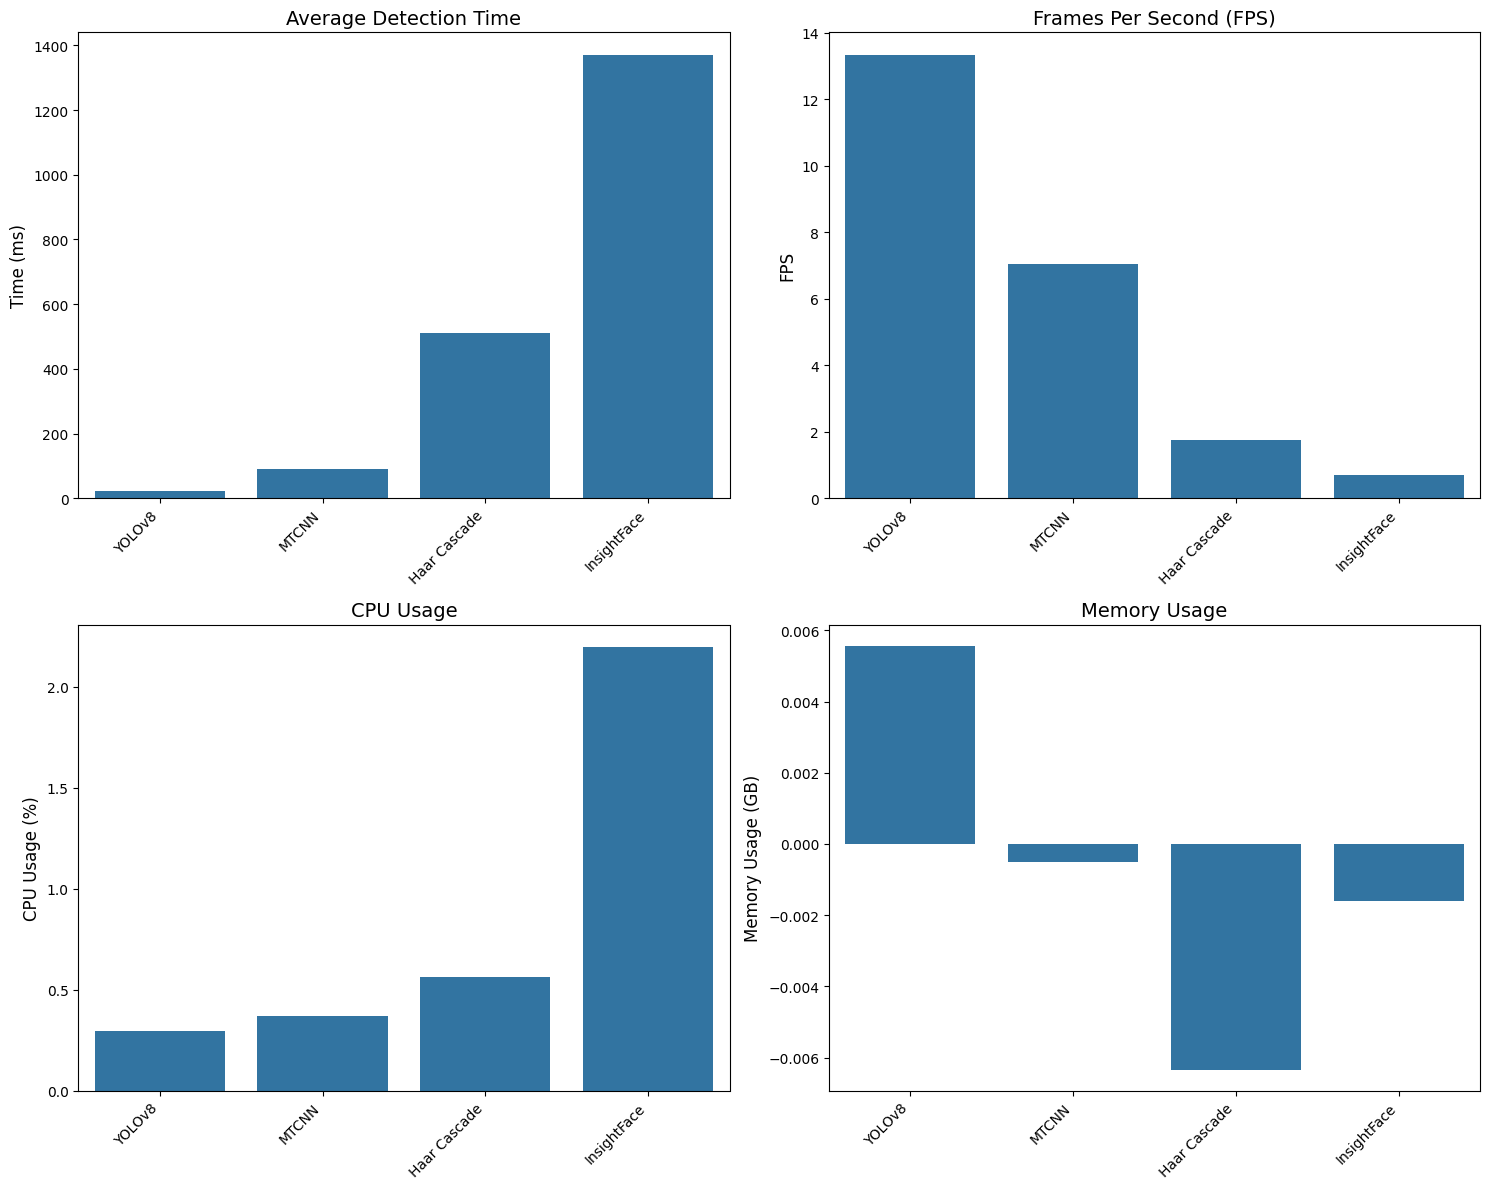


Challenging Case Comparisons:

Challenging Case: 7_Cheering_Cheering_7_451.jpg


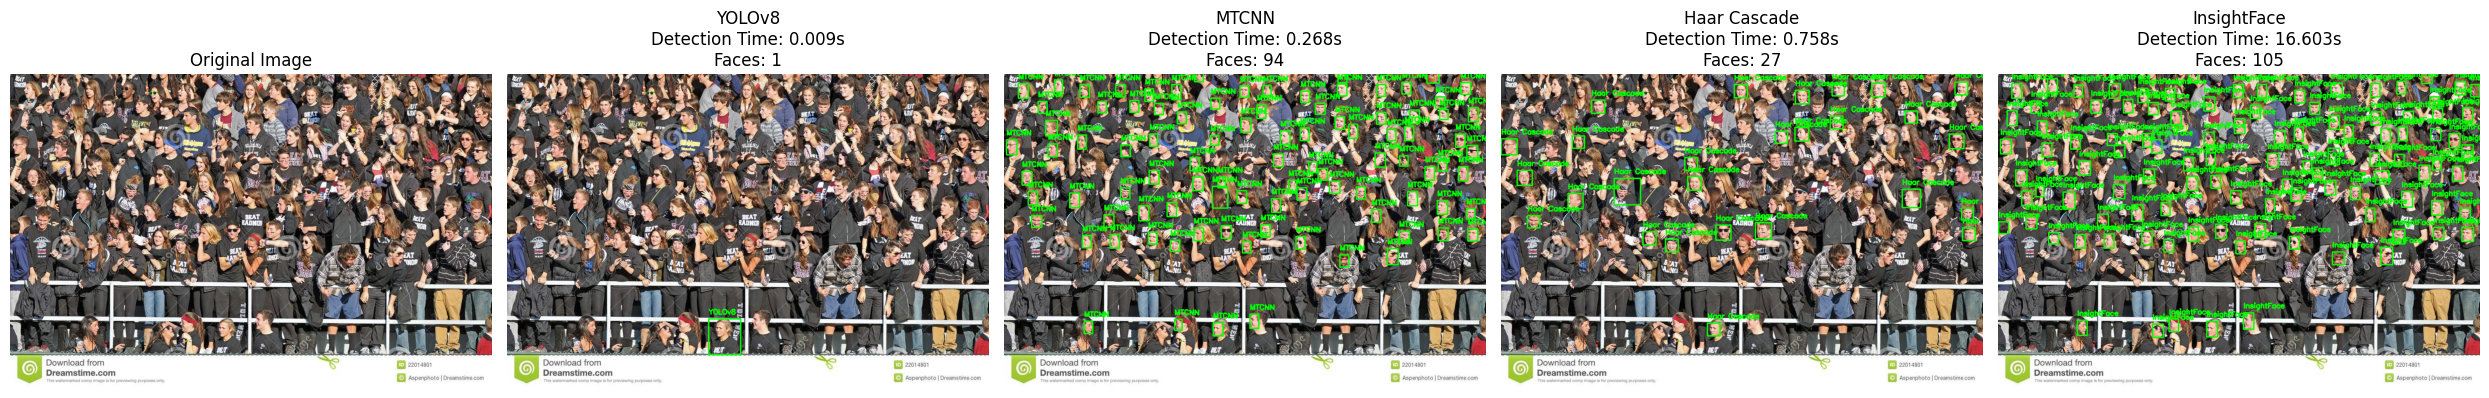


Challenging Case: 7_Cheering_Cheering_7_455.jpg


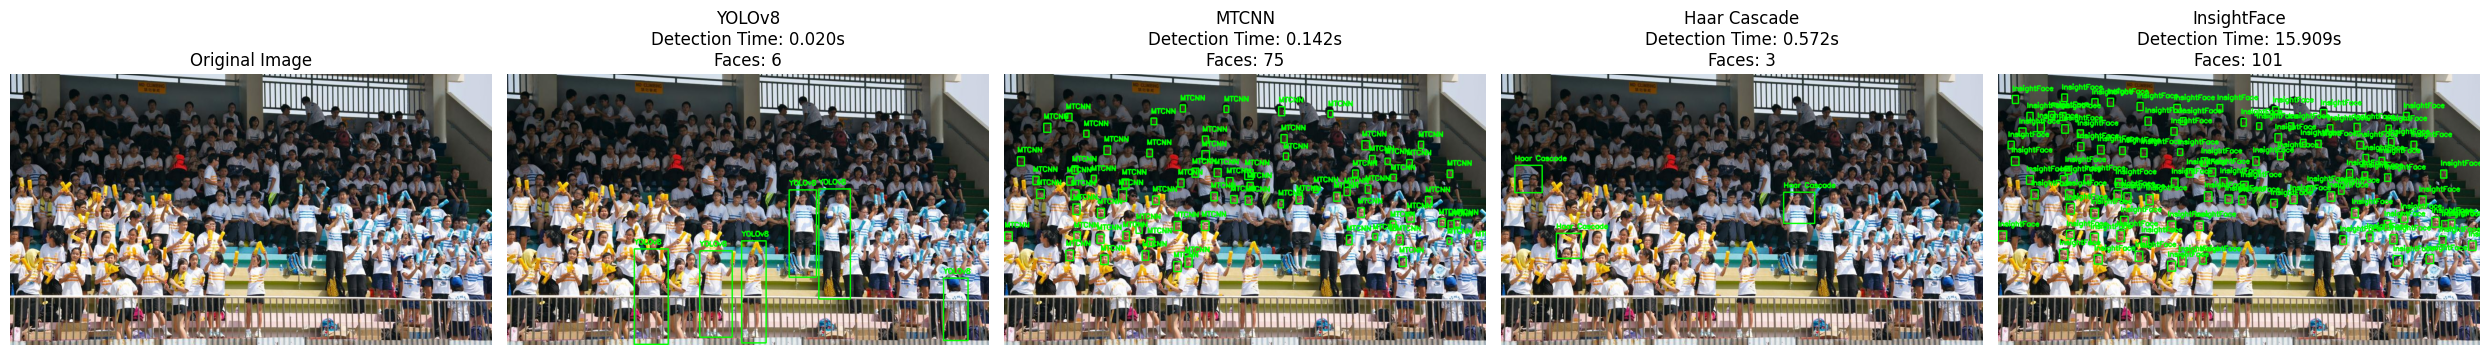


Challenging Case: 7_Cheering_Cheering_7_105.jpg


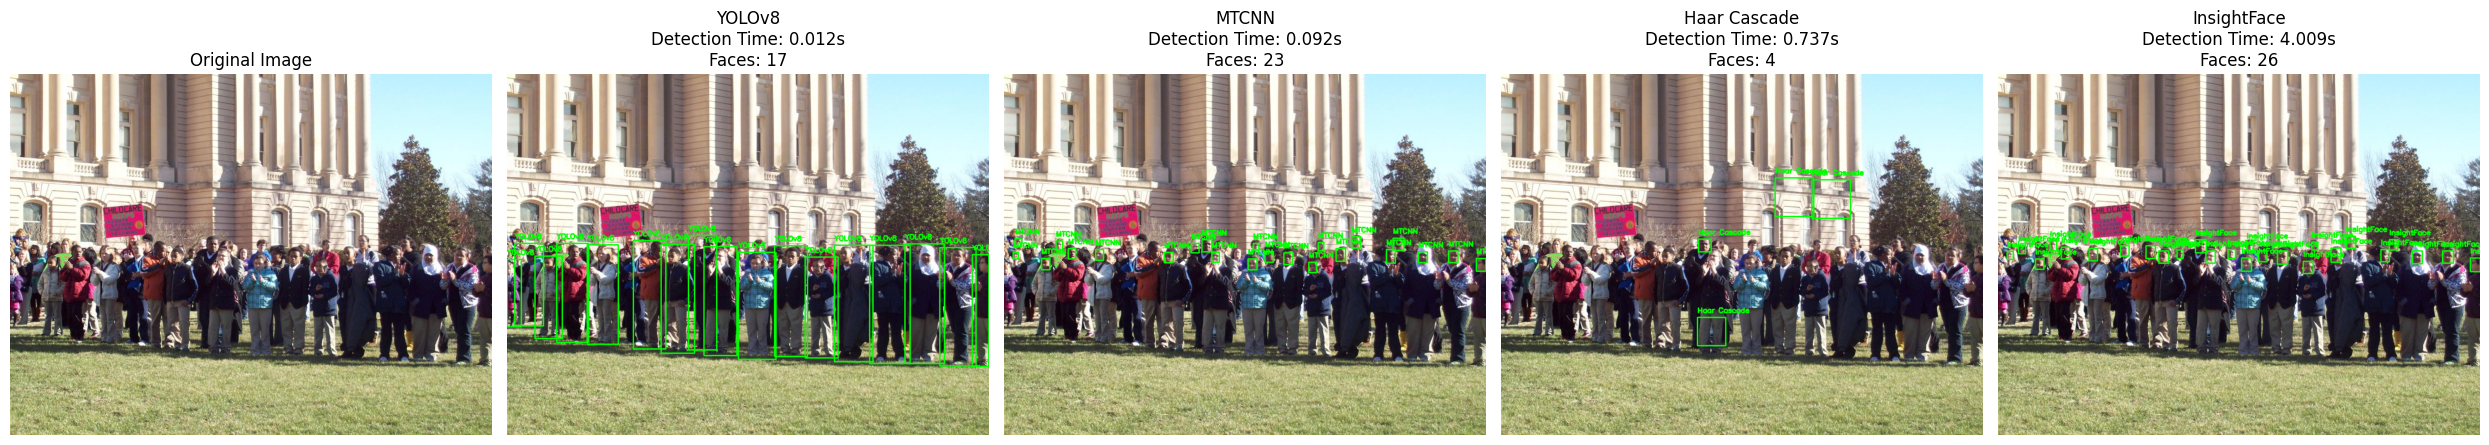


Challenging Case: 2_Demonstration_Political_Rally_2_156.jpg


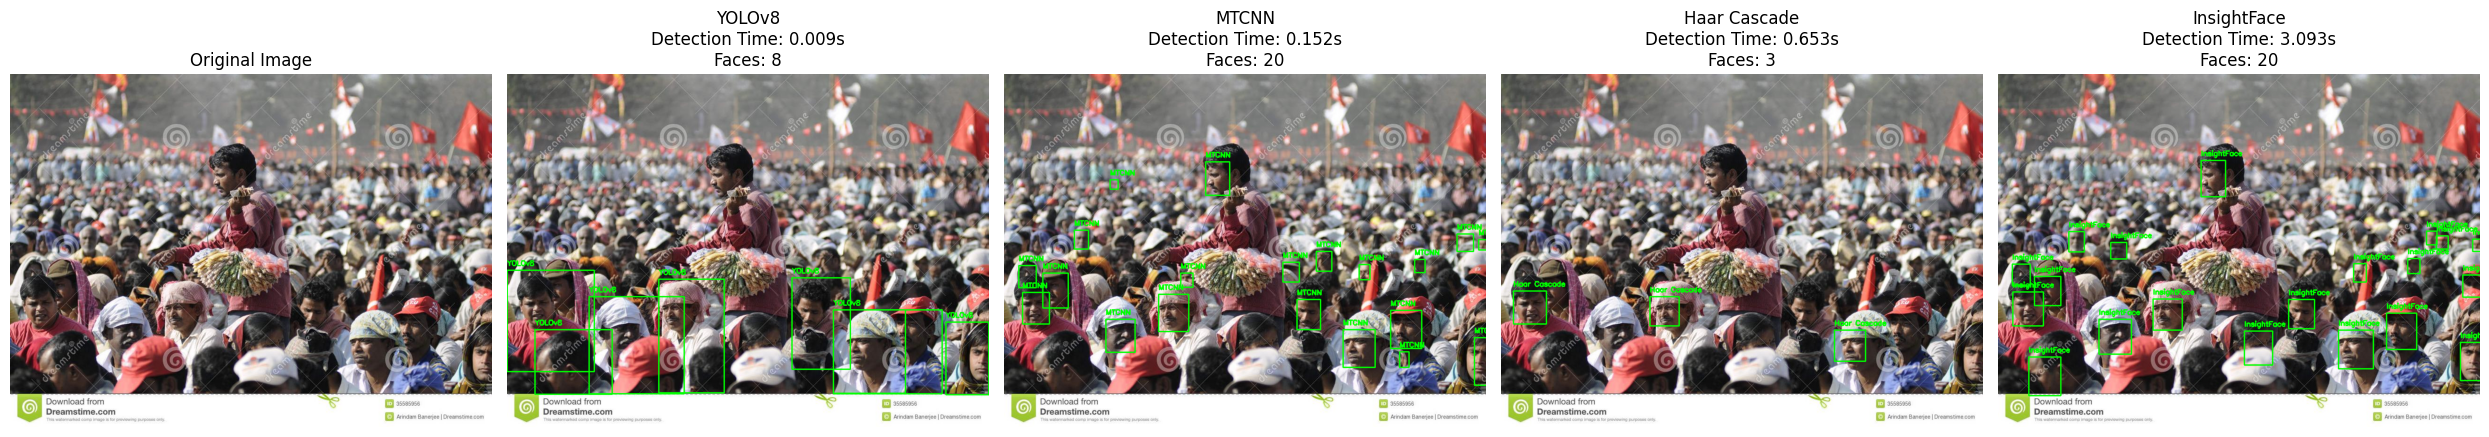


Challenging Case: 2_Demonstration_Demonstration_Or_Protest_2_144.jpg


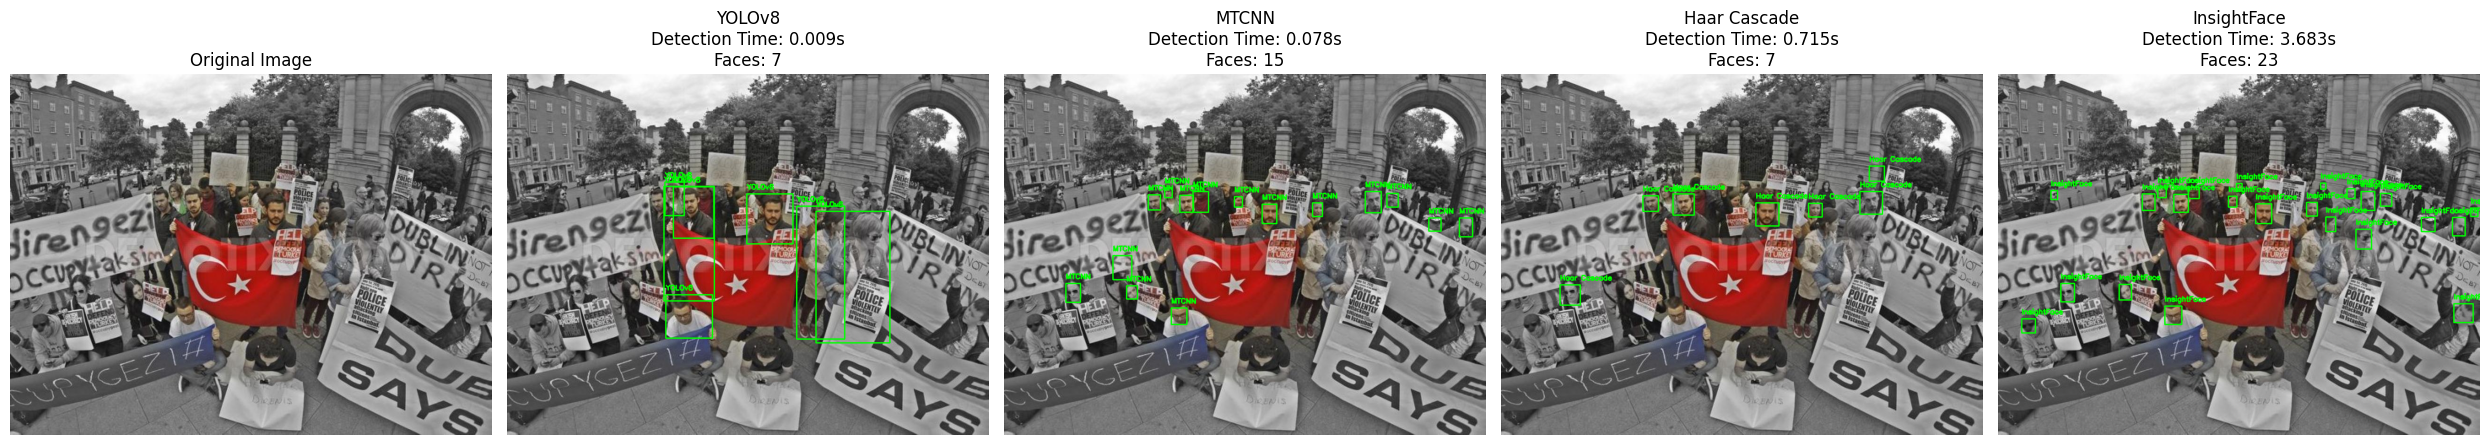

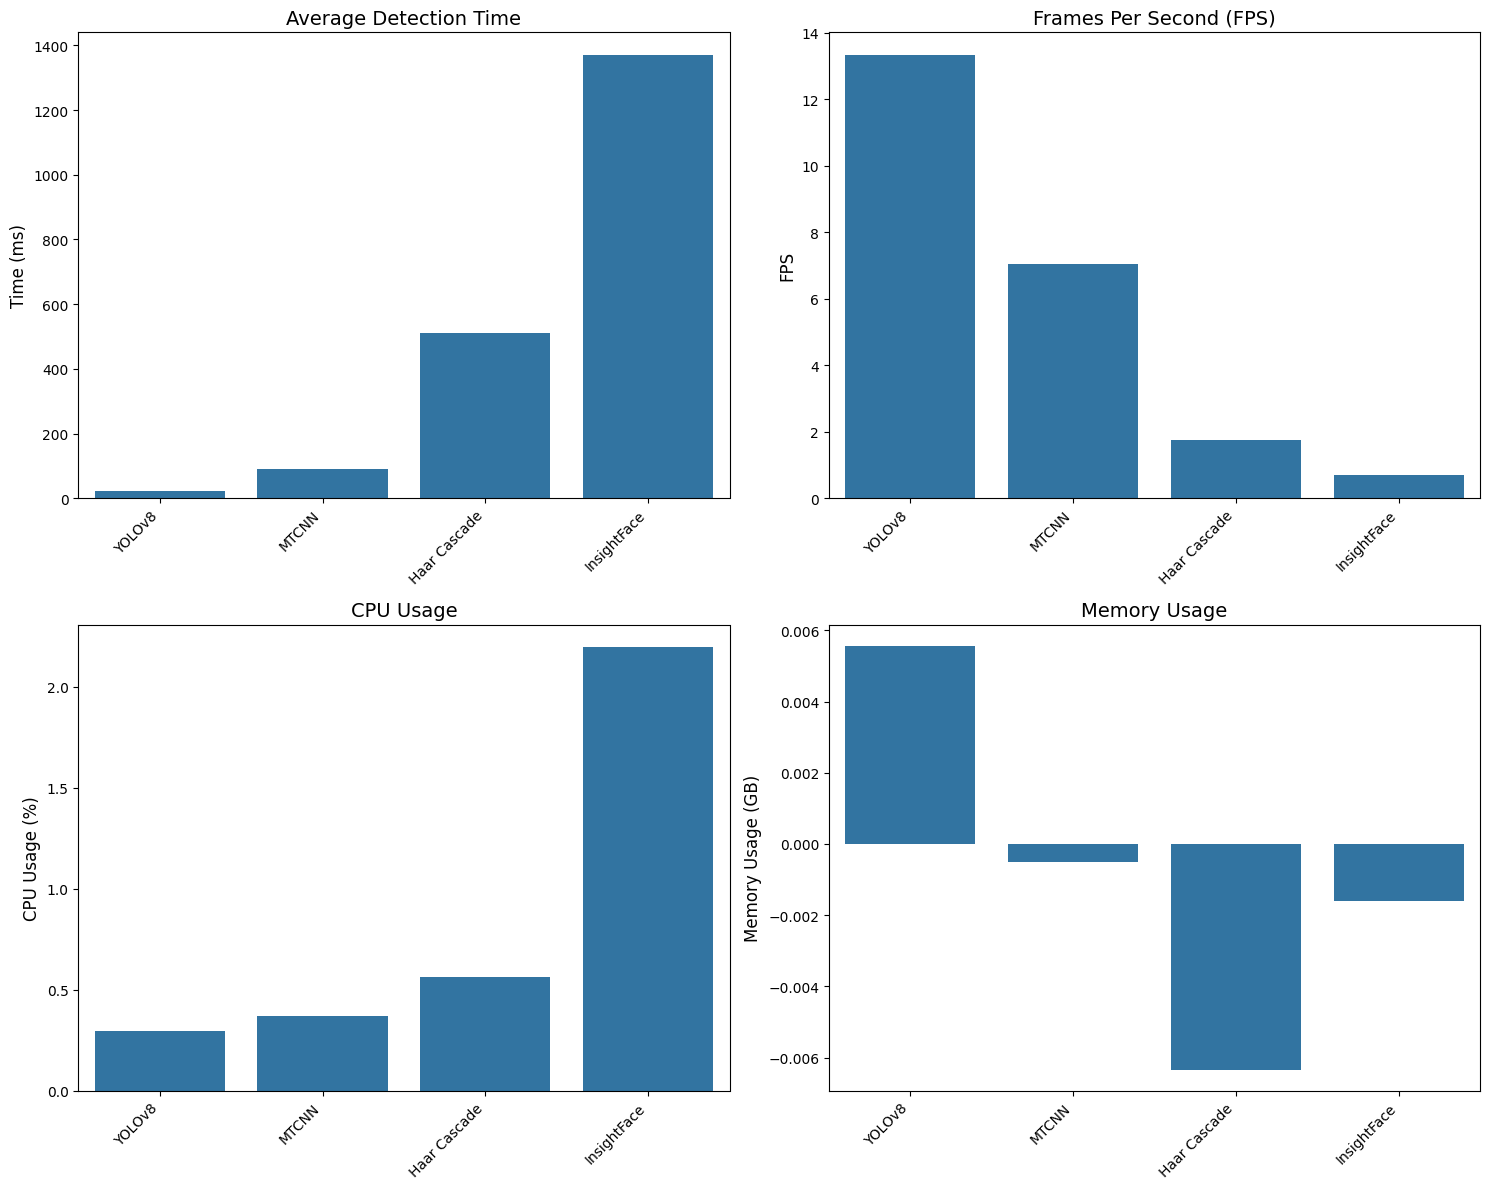

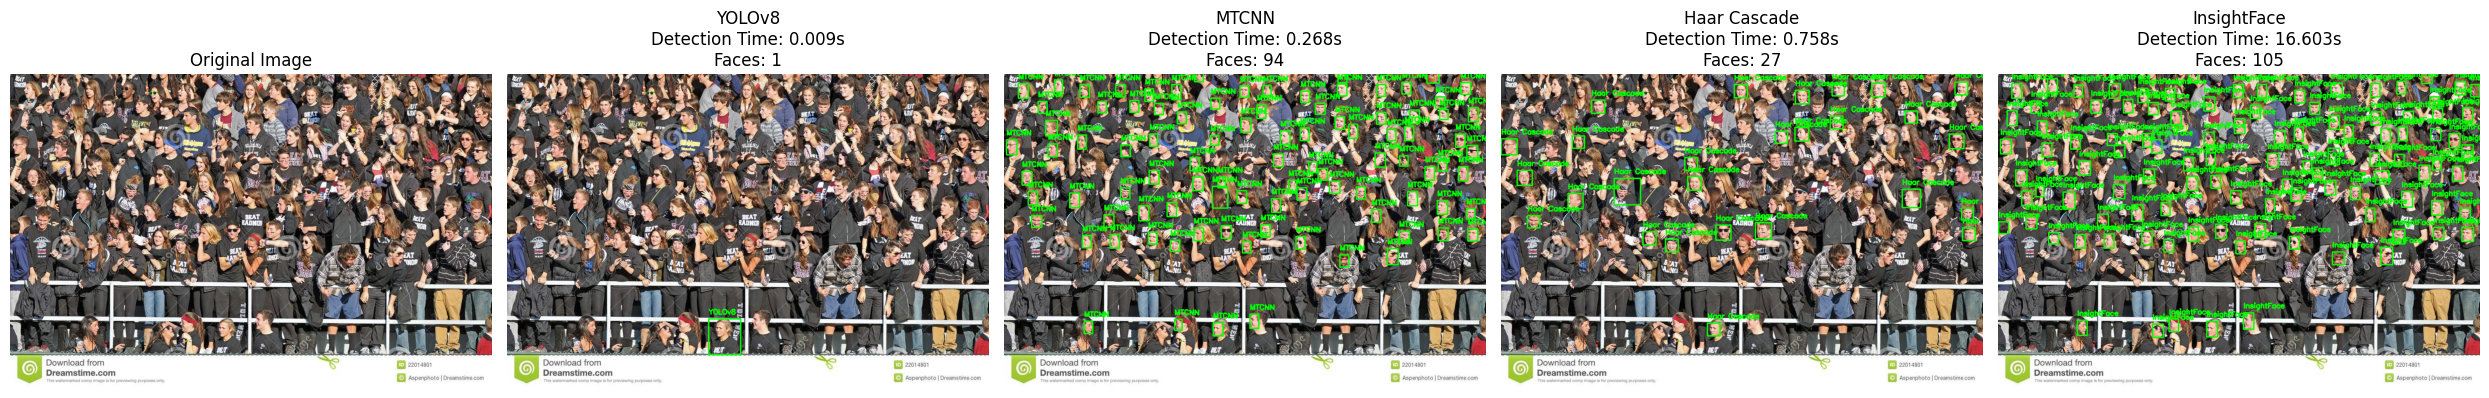

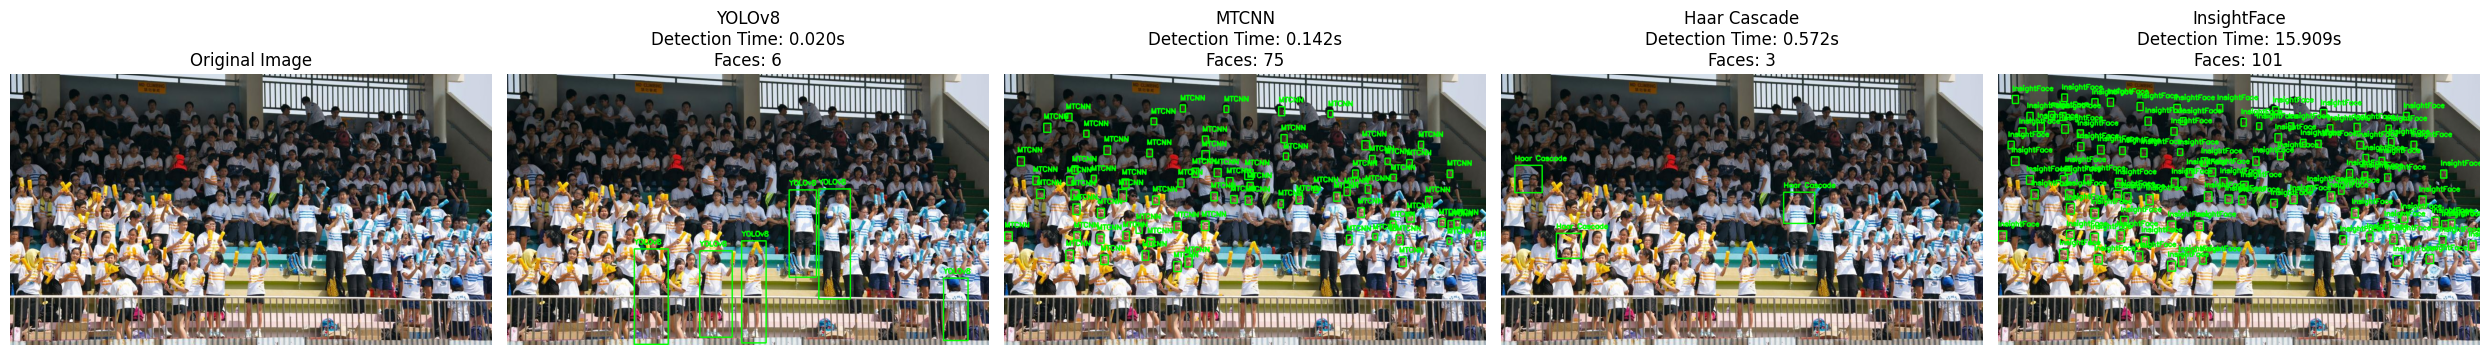

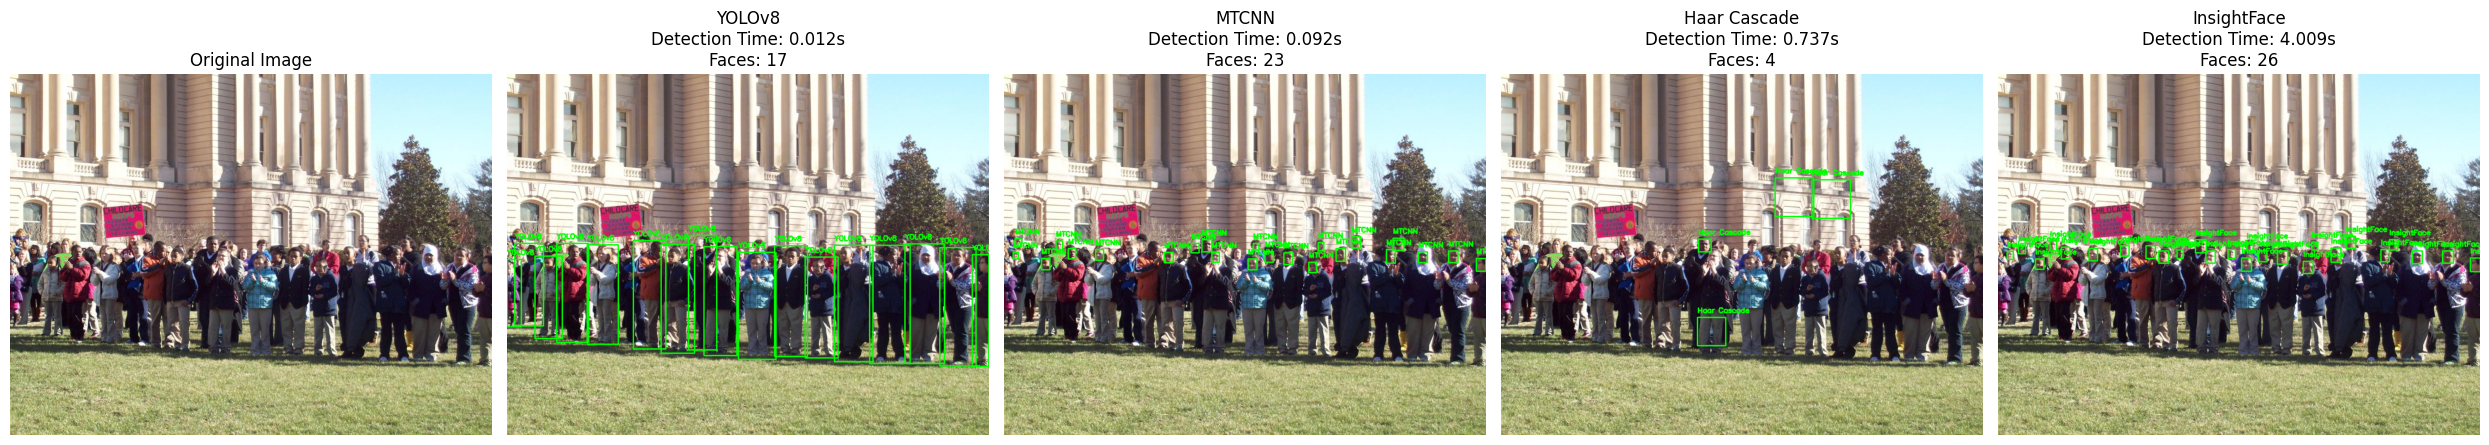

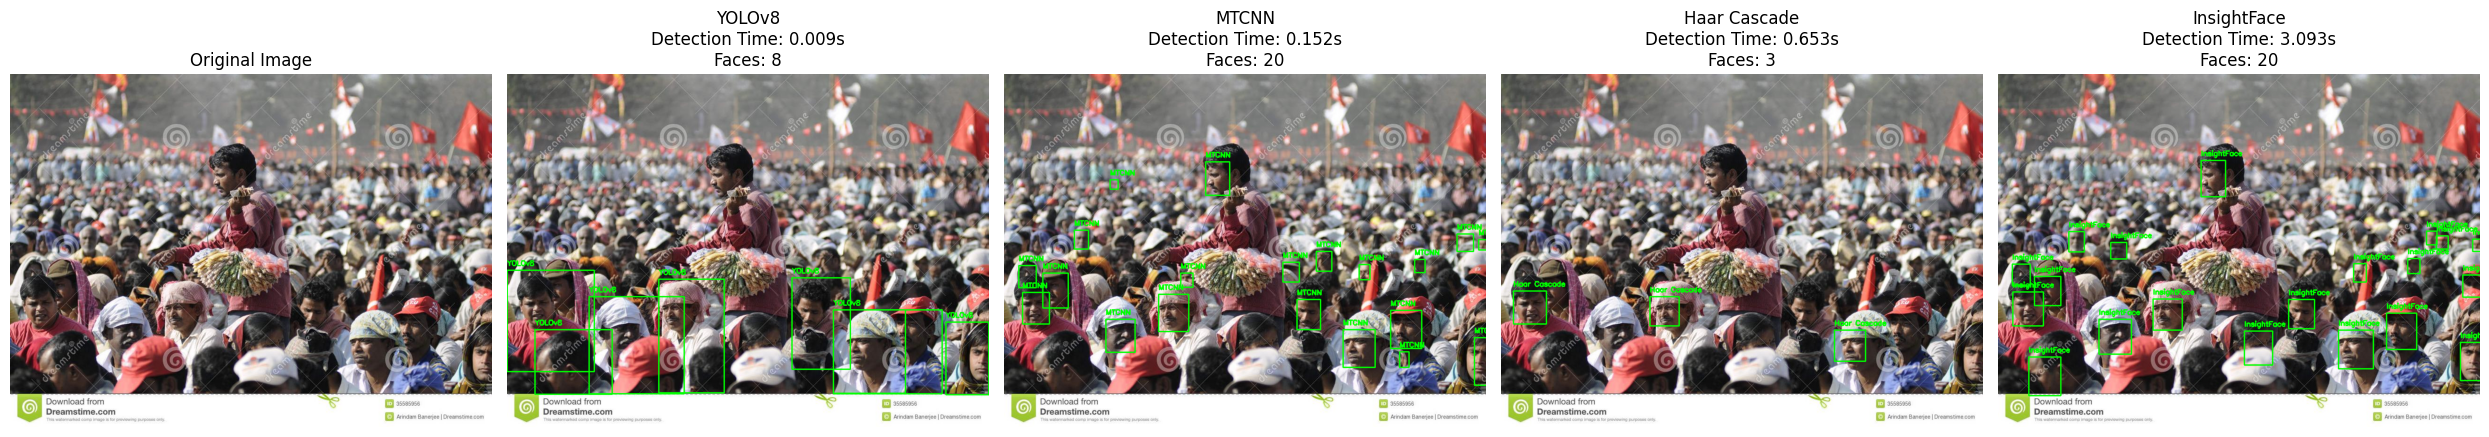

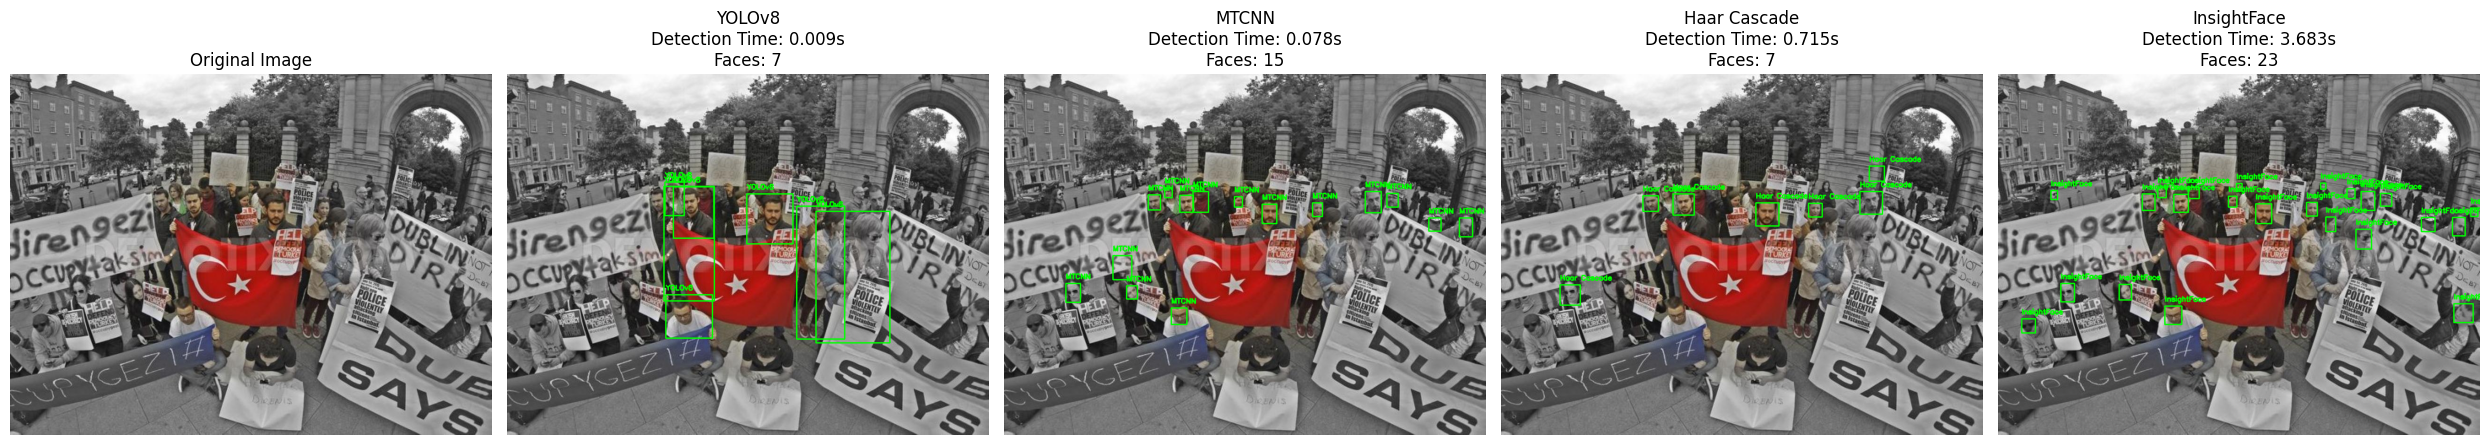

<Figure size 1500x1200 with 0 Axes>

In [7]:
# Comprehensive Model Evaluation and Comparison
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import cv2
import os
import seaborn as sns
from tqdm import tqdm
import torch
import psutil
import GPUtil

# Function to draw bounding boxes on images
def draw_detections(image, boxes, color=(0, 255, 0), thickness=2, label=None):
    """Draw detection boxes on an image"""
    img_copy = image.copy()
    for box in boxes:
        if len(box) >= 4:  # Ensure we have at least x1, y1, x2, y2
            x1, y1, x2, y2 = [int(coord) for coord in box[:4]]
            cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, thickness)
            
            # Add label if provided
            if label:
                cv2.putText(img_copy, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return img_copy

# Function to run all models on a single image and visualize results
def visualize_model_comparisons(image_path, models, detection_funcs, model_names):
    """Run all models on a single image and visualize the results side by side"""
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read image: {image_path}")
        return None
    
    # Create a figure with subplots for each model
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models + 1, figsize=(5 * (n_models + 1), 5))
    
    # Display original image
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Run each model and display results
    for i, (model, detect_func, name) in enumerate(zip(models, detection_funcs, model_names)):
        start_time = time.time()
        try:
            # Detect faces
            boxes = detect_func(model, img)
            
            # Draw bounding boxes
            detection_time = time.time() - start_time
            result_img = draw_detections(img, boxes, label=f"{name}")
            
            # Display the result
            axes[i+1].imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
            axes[i+1].set_title(f"{name}\nDetection Time: {detection_time:.3f}s\nFaces: {len(boxes)}")
            axes[i+1].axis('off')
        except Exception as e:
            print(f"Error with {name}: {e}")
            axes[i+1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[i+1].set_title(f"{name} - Error")
            axes[i+1].axis('off')
    
    plt.tight_layout()
    return fig

# Function to evaluate models on challenging cases
def evaluate_challenging_cases(models, detection_funcs, model_names, challenging_images):
    """Evaluate models on specific challenging cases"""
    results = []
    
    for img_path in challenging_images:
        fig = visualize_model_comparisons(img_path, models, detection_funcs, model_names)
        if fig:
            results.append((os.path.basename(img_path), fig))
    
    return results

# Function to create detailed performance visualizations
def create_detailed_visualizations(results):
    """Create detailed visualizations of performance metrics"""
    # Extract data from results
    model_names = [r['model_name'] for r in results]
    detection_times = [r['avg_detection_time'] * 1000 for r in results]  # Convert to ms
    fps_values = [r['avg_fps'] for r in results]
    cpu_usage = [r['avg_cpu_usage'] for r in results]
    memory_usage = [r['avg_memory_usage'] for r in results]
    
    # GPU usage if available
    gpu_usage = None
    if results[0]['avg_gpu_usage'] is not None:
        gpu_usage = [r['avg_gpu_usage'] for r in results]
    
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(15, 12))
    
    # Detection Time
    ax1 = fig.add_subplot(221)
    sns.barplot(x=model_names, y=detection_times, ax=ax1)
    ax1.set_title('Average Detection Time', fontsize=14)
    ax1.set_ylabel('Time (ms)', fontsize=12)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # FPS
    ax2 = fig.add_subplot(222)
    sns.barplot(x=model_names, y=fps_values, ax=ax2)
    ax2.set_title('Frames Per Second (FPS)', fontsize=14)
    ax2.set_ylabel('FPS', fontsize=12)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    
    # CPU Usage
    ax3 = fig.add_subplot(223)
    sns.barplot(x=model_names, y=cpu_usage, ax=ax3)
    ax3.set_title('CPU Usage', fontsize=14)
    ax3.set_ylabel('CPU Usage (%)', fontsize=12)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
    
    # Memory Usage
    ax4 = fig.add_subplot(224)
    sns.barplot(x=model_names, y=memory_usage, ax=ax4)
    ax4.set_title('Memory Usage', fontsize=14)
    ax4.set_ylabel('Memory Usage (GB)', fontsize=12)
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    return fig

# Function to create a detailed performance report
def create_performance_report(results):
    """Create a comprehensive performance report with tables and visualizations"""
    # Create performance comparison dataframe
    performance_data = {
        'Model': [r['model_name'] for r in results],
        'Avg Detection Time (ms)': [r['avg_detection_time'] * 1000 for r in results],
        'FPS': [r['avg_fps'] for r in results],
        'CPU Usage (%)': [r['avg_cpu_usage'] for r in results],
        'Memory Usage (GB)': [r['avg_memory_usage'] for r in results],
        'Avg Faces Detected': [np.mean(r['detected_faces']) for r in results]
    }
    
    if results[0]['avg_gpu_usage'] is not None:
        performance_data['GPU Usage (%)'] = [r['avg_gpu_usage'] for r in results]
    
    df_performance = pd.DataFrame(performance_data)
    
    # Create visualizations
    performance_fig = create_detailed_visualizations(results)
    
    return df_performance, performance_fig

# Function to find challenging test cases
def find_challenging_test_cases(test_images, models, detection_funcs, n_samples=5):
    """Find challenging test cases where models disagree"""
    challenging_cases = []
    
    for img_path, img in tqdm(test_images[:50], desc="Finding challenging cases"):  # Limit to first 50 images for speed
        detections = []
        
        for model, detect_func in zip(models, detection_funcs):
            try:
                faces = detect_func(model, img)
                if isinstance(faces, np.ndarray):
                    detections.append(len(faces))
                else:
                    detections.append(0)
            except Exception:
                detections.append(0)
        
        # Calculate standard deviation of number of detections
        std_dev = np.std(detections)
        
        # If models disagree significantly, consider it challenging
        if std_dev > 1.0:
            challenging_cases.append((img_path, std_dev))
    
    # Sort by standard deviation (most disagreement first)
    challenging_cases.sort(key=lambda x: x[1], reverse=True)
    
    # Return top n_samples challenging cases
    return [case[0] for case in challenging_cases[:n_samples]]

# Main evaluation function
def run_comprehensive_evaluation():
    """Run a comprehensive evaluation of all face detection models"""
    print("Starting comprehensive face detection model evaluation...")
    
    # Load all models
    print("Loading models...")
    yolo_model = load_yolo_model()
    mtcnn_model = load_mtcnn_model()
    haar_model = load_haar_cascade_model()
    insightface_model = load_insightface_model()
    
    # List of models, detection functions, and names
    models = [yolo_model, mtcnn_model, haar_model, insightface_model]
    detection_funcs = [detect_with_yolo, detect_with_mtcnn, detect_with_haar, detect_with_insightface]
    model_names = ["YOLOv8", "MTCNN", "Haar Cascade", "InsightFace"]
    
    # Filter out any models that failed to load
    valid_models = []
    valid_funcs = []
    valid_names = []
    
    for model, func, name in zip(models, detection_funcs, model_names):
        if model is not None:
            valid_models.append(model)
            valid_funcs.append(func)
            valid_names.append(name)
    
    # Evaluate each model
    print("Evaluating models...")
    results = []
    
    for model, func, name in zip(valid_models, valid_funcs, valid_names):
        print(f"Evaluating {name}...")
        result = evaluate_model(name, model, func, test_images, num_runs=1)
        results.append(result)
    
    # Create performance report
    print("Creating performance report...")
    performance_df, performance_fig = create_performance_report(results)
    
    # Find challenging test cases
    print("Finding challenging test cases...")
    challenging_cases = find_challenging_test_cases(test_images, valid_models, valid_funcs)
    
    # Evaluate models on challenging cases
    print("Evaluating models on challenging cases...")
    challenging_results = evaluate_challenging_cases(valid_models, valid_funcs, valid_names, challenging_cases)
    
    # Display results
    print("\nPerformance Comparison:")
    display(performance_df)
    
    print("\nDetailed Performance Visualization:")
    plt.figure(figsize=(15, 12))
    performance_fig.savefig('performance_comparison.png')
    display(performance_fig)
    
    print("\nChallenging Case Comparisons:")
    for name, fig in challenging_results:
        print(f"\nChallenging Case: {name}")
        fig.savefig(f'challenging_case_{name}.png')
        display(fig)
    
    return {
        'performance_df': performance_df,
        'performance_fig': performance_fig,
        'challenging_results': challenging_results
    }

# Run the comprehensive evaluation
evaluation_results = run_comprehensive_evaluation()
